# Setup

In [1]:
# Standard library imports
import json
import os
import random

# Related third-party imports
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from google import genai

This set of import statements prepares a Python program to perform several tasks related to data analysis, visualization, and interaction with a large language model.

First, the `json` module allows the code to work with JSON (JavaScript Object Notation) formatted data – commonly used for data exchange. The `os` module provides functions for interacting with the operating system, such as reading environment variables or managing files.  The `random` module enables the generation of random numbers, which might be useful for tasks like sampling or initialization.

Next, several third-party libraries are imported. `matplotlib.pyplot` is a plotting library used to create visualizations like graphs and charts. `numpy` provides support for numerical operations, especially working with arrays and matrices.  The `dotenv` module loads environment variables from a `.env` file, keeping sensitive information (like API keys) separate from the code itself. 

Then, time series analysis tools are brought in via `statsmodels`. Specifically, `ExponentialSmoothing`, `Holt`, and `SimpleExpSmoothing` classes will be used for forecasting and smoothing time-dependent data.

Finally, `google.genai` is imported to interface with Google’s Gemini large language model, allowing the program to generate text or perform other natural language processing tasks using that AI service.

In [2]:
# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42
    SES_ALPHA = 0.3


# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)

# fix randomness - insofar as possible ;-) 
np.random.seed(CFG.SEED)
random.seed(CFG.SEED)

This code segment establishes general settings and configurations for the program, along with some initial styling choices for visualizations.

A class named `CFG` is defined to hold constant values used throughout the application. It contains three attributes: `img_dim1` and `img_dim2`, which likely represent the dimensions (width and height) of images or plots in pixels; `SEED`, an integer value used to initialize random number generators for reproducibility; and `SES_ALPHA`, a floating-point number that appears to be a smoothing factor, potentially used within exponential smoothing algorithms.

Following this, the code customizes the appearance of plots created using `matplotlib`. It sets the default plotting style to "seaborn-v0_8" and configures the default figure size based on the dimensions defined in the `CFG` class (`img_dim1` and `img_dim2`).

To enhance reproducibility, the code then seeds the random number generators used by both `numpy` and the standard `random` module with the value stored in `CFG.SEED`. This ensures that if the program is run multiple times, it will generate the same sequence of random numbers, leading to consistent results where randomness is involved.

# Utils

In [3]:
def generate_synthetic_data() -> np.ndarray:

    time = np.arange(400, dtype=np.float32)
    series = np.zeros(400)

    # Period 1: Before the structural break (t < 200)
    series[:200] = 0.05 * time[:200] + \
                   5 * np.sin(time[:200] * 2 * np.pi / 12) + \
                   2 * np.sin(time[:200] * 2 * np.pi / 50) + 10

    # Period 2: After the structural break (t >= 200)
    series[200:] = 0.8 * (time[200:] - 200) + series[199] + \
                   5 * np.sin(time[200:] * 2 * np.pi / 12) + \
                   4 * np.sin(time[200:] * 2 * np.pi / 50)

    # Add some noise
    series += np.random.normal(0, 0.8, 400)
    return series

This function constructs a simulated time-series dataset with an abrupt change in its underlying pattern.

It begins by creating a NumPy array named `time` representing 400 equally spaced points in time, using the data type float32.  An array called `series`, also of length 400 and initialized with zeros, will store the generated time-series values.

The function then defines two distinct phases for the series. The first phase (from time 0 to 199) models a trend combined with periodic fluctuations. It calculates these values using a linear component (`0.05 * time[:200]`), two sine waves of differing frequencies (`5 * np.sin(...)` and `2 * np.sin(...)`) which introduce cyclical behavior, and a constant value (10) to set the baseline level.

At time step 200, there’s an intentional “structural break.” The second phase (from time 200 to 399) continues the periodic fluctuations but introduces a significantly steeper linear trend (`0.8 * (time[200:] - 200)`). This new trend starts from the value of the series at the point immediately before the break, ensuring continuity.

To make the data more realistic, random noise is added to the entire `series` using a normal distribution with a mean of zero and a standard deviation of 0.8.  Finally, the function returns the complete `series` array containing the synthetic time-series data.

In [4]:
def evaluate_forecast(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    return {'mae': mae, 'mse': mse}

This function, `evaluate_forecast`, assesses the accuracy of a time series forecast by calculating two common error metrics: Mean Absolute Error (MAE) and Mean Squared Error (MSE).

It takes two NumPy arrays as input: `y_true`, representing the actual observed values, and `y_pred`, containing the forecasted values. 

The function first computes the MAE by taking the absolute difference between each true value and its corresponding predicted value (`np.abs(y_true - y_pred)`), then calculating the average of these absolute differences using `np.mean()`.

Next, it calculates the MSE by finding the squared difference between each true value and its prediction (`(y_true - y_pred)**2`), and again computing the average of these squared differences. 

Finally, the function returns a dictionary containing both the calculated MAE and MSE values, with keys 'mae' and 'mse', respectively. This allows easy access to both error metrics for comparison or further analysis.

In [5]:
# tool 1 for the agent
def simple_exp_smoothing_tool(history_data: np.ndarray) -> np.ndarray:
    print("ACTION: Executing simple_exp_smoothing_tool (SES).")
    
    model = SimpleExpSmoothing(history_data, initialization_method="estimated")
    fit = model.fit(smoothing_level=CFG.SES_ALPHA, optimized=False)
    forecast = fit.forecast(forecast_horizon)
    return forecast


This function, `simple_exp_smoothing_tool`, implements a simple exponential smoothing (SES) forecasting method and is designed to be used as a tool within an agent-based system.

It accepts a NumPy array called `history_data` representing the historical time series data that will be used for forecasting. It begins by printing a message indicating that the SES tool is being executed, providing transparency about the agent’s actions. 

The core of the function involves creating and fitting an SES model using the `SimpleExpSmoothing` class from the `statsmodels` library. The historical data is passed to the constructor, and the `initialization_method` is set to "estimated," meaning the initial level of the series will be estimated from the data itself. 

The model is then fitted to the data using the `fit()` method.  Crucially, the `smoothing_level` parameter is set to `CFG.SES_ALPHA`, which retrieves a pre-defined smoothing factor from the configuration class. The `optimized=False` argument indicates that the smoothing level should not be optimized during fitting; it will remain fixed at the value specified in `CFG.SES_ALPHA`.

Finally, the function generates a forecast using the fitted model’s `forecast()` method.  The length of the forecast is determined by the global variable `forecast_horizon`. The resulting forecasted values are returned as a NumPy array.

In [6]:
# tool 2 for the agent - better model
def holt_winters_tool(history_data: np.ndarray, start_idx: int = 0, seasonal_periods: int = 12) -> np.ndarray:

    print(f"ACTION: Executing holt_winters_tool (Triple Exponential Smoothing) on data from index {start_idx} with seasonal_periods {seasonal_periods}.")
    
    fit_data = history_data[start_idx:]
    
    # We use 'add' for trend and 'add' for seasonal based on the synthetic data generation
    model = ExponentialSmoothing(
        fit_data, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=seasonal_periods,
        initialization_method="estimated"
    )
    fit = model.fit(optimized=True)
    forecast = fit.forecast(forecast_horizon)
    return forecast

This function, `holt_winters_tool`, implements a more sophisticated forecasting method – Holt-Winters’ exponential smoothing (also known as triple exponential smoothing) – and is intended for use as another tool within an agent-based system.

It takes the historical time series data (`history_data`) as input, along with optional parameters `start_idx` to specify the starting index of the data to be used for modeling, and `seasonal_periods` to define the length of the seasonal cycle in the data. It begins by printing a message indicating that the Holt-Winters tool is being executed, including the start index and seasonal period settings.

The function then extracts a subset of the historical data from the specified starting index onwards (`fit_data = history_data[start_idx:]`). This allows for focusing on more recent data or excluding initial irrelevant portions of the time series.

Next, it creates an `ExponentialSmoothing` model (which encompasses Holt-Winters as a special case) using the extracted data. The `trend='add'` and `seasonal='add'` arguments specify that both trend and seasonality are modeled additively – this choice is based on how the synthetic data was generated.  The `seasonal_periods` parameter sets the length of the seasonal cycle, defaulting to 12. The `initialization_method="estimated"` argument indicates that initial values for the level, trend, and seasonal components will be estimated from the data.

The model is then fitted to the data using the `fit()` method with `optimized=True`, which means the smoothing parameters (alpha, beta, gamma) are automatically optimized to minimize the error on the training data. 

Finally, a forecast for the specified `forecast_horizon` is generated using the fitted model’s `forecast()` method and returned as a NumPy array.

# Prep work

In [7]:
# Generate and split the data
full_series = generate_synthetic_data()
history = full_series[:300]
future = full_series[300:]
forecast_horizon = len(future)

This code segment prepares the synthetic time series data for forecasting by splitting it into training (history) and testing (future) sets.

First, it calls the `generate_synthetic_data()` function to create a complete time series dataset and stores it in the variable `full_series`. 

Then, it divides this full series into two parts: `history` contains the first 300 data points, which will be used as the training set for building forecasting models.  The remaining portion of the series, from index 300 onwards, is assigned to `future`, representing the test set – the period that the model will attempt to predict.

Finally, it determines the length of the `future` array and assigns this value to the global variable `forecast_horizon`. This variable represents how many time steps into the future the forecasting models should predict. Essentially, `forecast_horizon` defines the prediction window size.

In [8]:
# Gemini connection
load_dotenv()
gemini_client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))


This code establishes a connection to Google’s Gemini large language model through its API.

It begins by calling `load_dotenv()` which loads environment variables from a `.env` file into the program's environment. This is a secure way to store sensitive information like API keys, preventing them from being hardcoded directly into the code. 

Next, it creates an instance of the `genai.Client` class, passing in the Gemini API key as the `api_key` argument. The API key is retrieved from the environment variables using `os.getenv("GEMINI_API_KEY")`. This client object will be used to interact with the Gemini model for tasks like generating text or analyzing data.

In [9]:

SYSTEM_PROMPT = """
You are an expert time series forecasting agent. You have access to the following tools:

1. simple_exp_smoothing_tool: Simple Exponential Smoothing (SES) - best for stationary data without trend.
   Produces flat forecasts. Good for stable, mean-reverting series.
   Parameters: none

2. hw_tool: Triple Exponential Smoothing (Holt-Winters method) - best for data with a trend and seasonality.
   Can capture and extrapolate linear trends. Can fit on a subset of history.
   Parameters: start_idx (int, optional, default=0) - the starting index to use for fitting.

Your task is to analyze the situation and decide which tool to use.
You must respond with ONLY a valid JSON object (no markdown, no explanation) in this exact format:
{
    "thought": "Your reasoning about the situation",
    "tool_name": "simple_exp_smoothing_tool" or "hw_tool",
    "parameters": {} or {"start_idx": <integer>}
}
"""

This code defines a system prompt that will be used to instruct a large language model (specifically, Google’s Gemini) acting as a time series forecasting agent.

The `SYSTEM_PROMPT` variable contains a detailed set of instructions for the agent. It establishes the agent's role as an expert in time series forecasting and outlines the available tools: `simple_exp_smoothing_tool` and `hw_tool` (Holt-Winters). For each tool, it provides a description of its strengths, weaknesses, and appropriate use cases.

The prompt also specifies that the agent’s task is to analyze a given situation and select the most suitable forecasting tool. It strictly enforces a specific JSON output format for the agent's response, requiring a "thought" field explaining the reasoning behind the tool selection, a "tool_name" field indicating which tool was chosen, and a "parameters" field containing any necessary parameters for that tool (which may be an empty dictionary if no parameters are needed). The prompt explicitly prohibits markdown or explanatory text outside of the JSON structure.

In [10]:
# toolkit for the agent

toolkit = {
    "simple_exp_smoothing_tool": simple_exp_smoothing_tool,
    "hw_tool": holt_winters_tool
}


This code creates a dictionary called `toolkit` that maps tool names to their corresponding functions. 

The keys of the dictionary are strings representing the names of the tools available to the agent: "simple_exp_smoothing_tool" and "hw_tool". The values associated with these keys are the actual Python function objects (`simple_exp_smoothing_tool` and `holt_winters_tool`) that implement those tools.

This `toolkit` dictionary serves as a central repository for accessing the agent’s available functionalities, allowing the language model to dynamically call the appropriate function based on its decision-making process.

In [11]:
def gemini_agent(prompt: str) -> dict:

    print("--- Agent is PLANNING ---")
    print(f"PROMPT: \n{prompt}\n")
    
    full_prompt = f"{SYSTEM_PROMPT}\n\nUser request:\n{prompt}"
    
    response = gemini_client.models.generate_content(
        model="gemini-2.0-flash-lite",
        contents=full_prompt
    )
    
    response_text = response.text.strip()
    # Clean up potential markdown formatting
    if response_text.startswith("```json"):
        response_text = response_text[7:]
    if response_text.startswith("```"):
        response_text = response_text[3:]
    if response_text.endswith("```"):
        response_text = response_text[:-3]
    response_text = response_text.strip()
    
    plan = json.loads(response_text)
    
    print(f"AGENT's PLAN: \n{json.dumps(plan, indent=2)}\n")
    return plan

This function, `gemini_agent`, orchestrates the interaction with the Gemini language model to obtain a forecasting plan.

It takes a string `prompt` as input, which represents the user’s request or the current situation requiring a forecast. It begins by printing messages indicating that the agent is in the planning phase and displaying the prompt being sent to Gemini.

The function then constructs a complete prompt (`full_prompt`) by combining the pre-defined `SYSTEM_PROMPT` (which provides instructions to the agent) with the user’s specific request. This combined prompt is then sent to the Gemini model using the `gemini_client.models.generate_content()` method, specifying the "gemini-2.0-flash-lite" model and passing in the full prompt as the content.

The response from Gemini is extracted as text (`response.text`) and any leading or trailing code block markers (e.g., “```json”, “```”) are removed to ensure clean JSON parsing. The cleaned text is then parsed into a Python dictionary using `json.loads()`. 

Finally, the function prints the agent’s generated plan in a nicely formatted JSON structure (using `json.dumps()` with indentation) and returns the plan as a dictionary. This plan will contain information about which tool to use and any associated parameters, as defined by the `SYSTEM_PROMPT`.

In [12]:

def run_atsf_workflow(history_data: np.ndarray, ground_truth: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

    # === CYCLE 1: Initial Forecast ===
    print("CYCLE 1: ")
    
    # 1. PERCEPTION: Agent receives the initial task.
    initial_prompt = "Forecast the next 100 time steps for the provided series. Choose the best tool to start with."
    
    # 2. PLANNING: Agent formulates a plan.
    plan_1 = gemini_agent(initial_prompt)
    
    # 3. ACTION: Execute the plan.
    tool_to_use = toolkit[plan_1['tool_name']]
    initial_forecast = tool_to_use(history_data, **plan_1['parameters'])
    
    # Evaluate the first attempt
    metrics_1 = evaluate_forecast(ground_truth, initial_forecast)
    print(f"\nInitial Forecast Performance (Cycle 1): MAE={metrics_1['mae']:.2f}, MSE={metrics_1['mse']:.2f}\n")

    # === CYCLE 2: Reflection and Refinement ===
    print("CYCLE 2:")
    
    # 4. REFLECTION: Agent perceives the poor outcome and is prompted to reflect.
    reflection_prompt = f"""
    Reflect on the poor performance of the initial forecast (MAE: {metrics_1['mae']:.2f}). 
    The historical data spans 300 time steps, and there appears to be a structural break around t=200 
    where the trend becomes significantly steeper.
    Hypothesize a reason for the failure and formulate a new, improved plan.
    Consider using data only from after the structural break (index 200 onwards) for a simpler model.
    """
    
    # 5. RE-PLANNING: Agent re-evaluates and creates a new plan.
    plan_2 = gemini_agent(reflection_prompt)
    
    # 6. ACTION (Revised): Execute the new plan.
    tool_to_use = toolkit[plan_2['tool_name']]
    final_forecast = tool_to_use(history_data, **plan_2['parameters'])
    
    # Evaluate the final attempt
    metrics_2 = evaluate_forecast(ground_truth, final_forecast)
    print(f"\nFinal Forecast Performance (Cycle 2): MAE={metrics_2['mae']:.2f}, MSE={metrics_2['mse']:.2f}\n")

    
    return initial_forecast, final_forecast



This function, `run_atsf_workflow`, implements a two-cycle agent-based time series forecasting workflow that incorporates reflection and refinement.

It takes the historical data (`history_data`) and the ground truth (actual values for the forecast period, `ground_truth`) as input and returns both the initial and final forecasts generated by the agent.

**Cycle 1: Initial Forecast**

The first cycle begins with a "perception" step where the agent receives an initial prompt requesting a forecast of the next 100 time steps. The `gemini_agent` function is called to generate a plan based on this prompt, specifying which tool to use and any necessary parameters.  The selected tool (retrieved from the `toolkit` dictionary) is then executed with the historical data and parameters, producing an initial forecast.

The performance of this initial forecast is evaluated using the `evaluate_forecast` function, calculating MAE and MSE metrics. These metrics are printed to provide feedback on the initial attempt.

**Cycle 2: Reflection and Refinement**

The second cycle focuses on improving the forecast based on the results from Cycle 1. The agent "reflects" on the poor performance of the initial forecast by receiving a new prompt that provides information about the MAE, MSE, and characteristics of the data (specifically mentioning a structural break around time step 200).

The agent is prompted to hypothesize why the first attempt failed and formulate an improved plan. Again, `gemini_agent` is called with this reflection prompt to generate a revised plan. The new plan’s tool is executed using the historical data and parameters, resulting in a final forecast.

Finally, the performance of the final forecast is evaluated using `evaluate_forecast`, and the MAE and MSE metrics are printed. 

The function then returns both the initial and final forecasts as a tuple, allowing for comparison and analysis of the impact of the reflection and refinement process. This workflow demonstrates an iterative approach to forecasting where the agent learns from its mistakes and adapts its strategy to improve accuracy.

# Run Forrest run

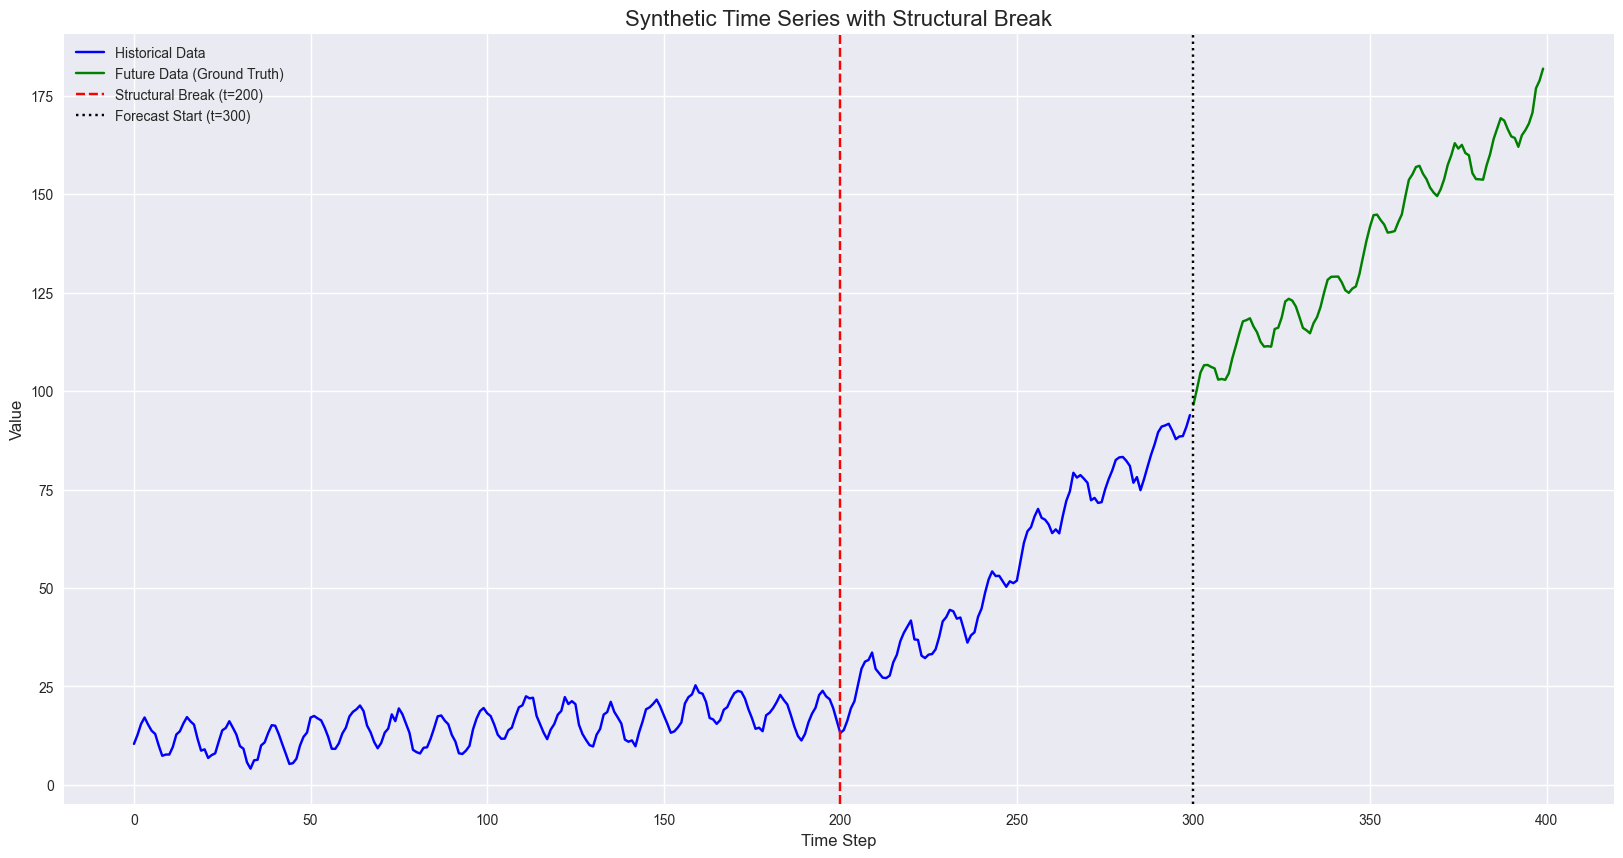

In [13]:
    plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
    plt.plot(np.arange(300), history, label='Historical Data', color='blue')
    plt.plot(np.arange(300, 400), future, label='Future Data (Ground Truth)', color='green')
    plt.axvline(x=200, color='red', linestyle='--', label='Structural Break (t=200)')
    plt.axvline(x=300, color='black', linestyle=':', label='Forecast Start (t=300)')
    plt.title('Synthetic Time Series with Structural Break', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.show()

This code generates a visualization of the synthetic time series data, highlighting key features like the structural break and the point at which forecasting begins.

It starts by creating a new figure with dimensions specified in the `CFG` class (`img_dim1` and `img_dim2`).  Then, it plots the historical data (the first 300 time steps) as a blue line labeled "Historical Data." The ground truth future data (from time step 300 to 400) is plotted as a green line labeled “Future Data (Ground Truth).”

A vertical dashed red line is added at x=200 to visually indicate the location of the structural break in the series. Another vertical dotted black line is drawn at x=300, marking the beginning of the forecast period. 

The plot is then enhanced with a title ("Synthetic Time Series with Structural Break"), axis labels ("Time Step" and "Value"), and a legend to identify each plotted element. Finally, `plt.show()` displays the generated plot. This visualization provides a clear overview of the data used for forecasting and helps in understanding the challenges posed by the structural break.

In [14]:
    print(f"Total series length: {len(full_series)}")
    print(f"Historical data length: {len(history)}")
    print(f"Future data length (forecast horizon): {len(future)}")

Total series length: 400
Historical data length: 300
Future data length (forecast horizon): 100


In [15]:
    # Generate Baseline Forecast using Simple Exponential Smoothing
    print("\nGenerating baseline forecast with Simple Exponential Smoothing...")
    baseline_pred = simple_exp_smoothing_tool(history)
    baseline_metrics = evaluate_forecast(future, baseline_pred)
    print(f"\nBaseline Model-Centric Performance:")
    print(f"  MAE: {baseline_metrics['mae']:.4f}")
    print(f"  MSE: {baseline_metrics['mse']:.4f}")


Generating baseline forecast with Simple Exponential Smoothing...
ACTION: Executing simple_exp_smoothing_tool (SES).

Baseline Model-Centric Performance:
  MAE: 46.2871
  MSE: 2642.9825


This code segment establishes a baseline forecasting performance using Simple Exponential Smoothing (SES).

It begins by printing a message indicating that a baseline forecast is being generated using SES. The `simple_exp_smoothing_tool` function is called with the historical data (`history`) to produce a forecast, and the result is stored in `baseline_pred`. 

The performance of this baseline forecast is then evaluated by comparing it to the actual future values (`future`) using the `evaluate_forecast` function. The resulting MAE and MSE metrics are stored in `baseline_metrics`.

Finally, the code prints a heading ("Baseline Model-Centric Performance:") followed by the calculated MAE and MSE values, formatted to four decimal places. This provides a quantitative measure of how well SES performs on this dataset without any agent intervention or refinement, serving as a benchmark for evaluating the more sophisticated forecasting approaches used later in the workflow.

In [16]:
    # Run the Agentic Workflow
    initial_agent_forecast, final_agent_forecast = run_atsf_workflow(history, future)


CYCLE 1: 
--- Agent is PLANNING ---
PROMPT: 
Forecast the next 100 time steps for the provided series. Choose the best tool to start with.

AGENT's PLAN: 
{
  "thought": "I need to analyze the time series to determine if it has a trend or seasonality. Without seeing the series, I'll start with the more general approach, Holt-Winters, as it can handle both trend and seasonality. If the series appears stationary without trend or seasonality, I'll revise to SES.",
  "tool_name": "hw_tool",
  "parameters": {}
}

ACTION: Executing holt_winters_tool (Triple Exponential Smoothing) on data from index 0 with seasonal_periods 12.

Initial Forecast Performance (Cycle 1): MAE=29.31, MSE=1190.13

CYCLE 2:
--- Agent is PLANNING ---
PROMPT: 

    Reflect on the poor performance of the initial forecast (MAE: 29.31). 
    The historical data spans 300 time steps, and there appears to be a structural break around t=200 
    where the trend becomes significantly steeper.
    Hypothesize a reason for the 

This line of code executes the core agent-based time series forecasting workflow.

It calls the `run_atsf_workflow` function, passing in the historical data (`history`) and the ground truth future data (`future`). The `run_atsf_workflow` function orchestrates a two-cycle process involving initial forecasting, reflection on performance, re-planning, and refined forecasting using an agent powered by the Gemini language model.

The function returns two NumPy arrays: `initial_agent_forecast`, representing the forecast generated in the first cycle, and `final_agent_forecast`, representing the improved forecast produced after the reflection and refinement process. These forecasts are then stored in the respective variables for further analysis or visualization.

In [17]:

    # Calculate final metrics
    agent_final_metrics = evaluate_forecast(future, final_agent_forecast)

This code calculates the performance metrics for the final forecast generated by the agentic workflow.

It calls the `evaluate_forecast` function, passing in the ground truth future data (`future`) and the final forecast produced by the agent (`final_agent_forecast`). The resulting MAE and MSE values are returned as a dictionary and stored in the variable `agent_final_metrics`. This allows for quantifying how well the agent performed after its reflection and refinement process.

In [18]:
    # Display Results
    print("\n| Approach                    |   MAE   |   MSE   |")
    print("|-----------------------------|---------|---------")
    print(f"| Model-Centric (Baseline)    | {baseline_metrics['mae']:>7.2f} | {baseline_metrics['mse']:>7.2f} |")
    print(f"| Agentic (ATSF Final)        | {agent_final_metrics['mae']:>7.2f} | {agent_final_metrics['mse']:>7.2f} |")
    
    improvement_mae = (baseline_metrics['mae'] - agent_final_metrics['mae']) / baseline_metrics['mae'] * 100
    improvement_mse = (baseline_metrics['mse'] - agent_final_metrics['mse']) / baseline_metrics['mse'] * 100
    
    print("\n--- Performance Improvement ---")
    print(f"The agentic approach improved MAE by {improvement_mae:.2f}% over the baseline.")
    print(f"The agentic approach improved MSE by {improvement_mse:.2f}% over the baseline.")
    
  


| Approach                    |   MAE   |   MSE   |
|-----------------------------|---------|---------
| Model-Centric (Baseline)    |   46.29 | 2642.98 |
| Agentic (ATSF Final)        |   31.38 | 1358.21 |

--- Performance Improvement ---
The agentic approach improved MAE by 32.20% over the baseline.
The agentic approach improved MSE by 48.61% over the baseline.


This code segment presents a clear and organized comparison of the forecasting performance between the baseline model (Simple Exponential Smoothing) and the agentic workflow.

It begins by printing a formatted table header with columns for "Approach," "MAE," and "MSE." Then, it prints two rows: one displaying the MAE and MSE values for the baseline model (`baseline_metrics`), and another showing the corresponding metrics for the final forecast generated by the agentic workflow (`agent_final_metrics`). The numbers are right-aligned within their columns for improved readability.

Next, it calculates the percentage improvement in both MAE and MSE achieved by the agentic approach compared to the baseline. This is done by subtracting the agent’s metric from the baseline metric, dividing the result by the baseline metric, and multiplying by 100.

Finally, it prints a section titled "Performance Improvement" and displays the calculated percentage improvements for MAE and MSE, formatted to two decimal places. This provides a concise summary of how much better the agentic workflow performed compared to the simple baseline model.

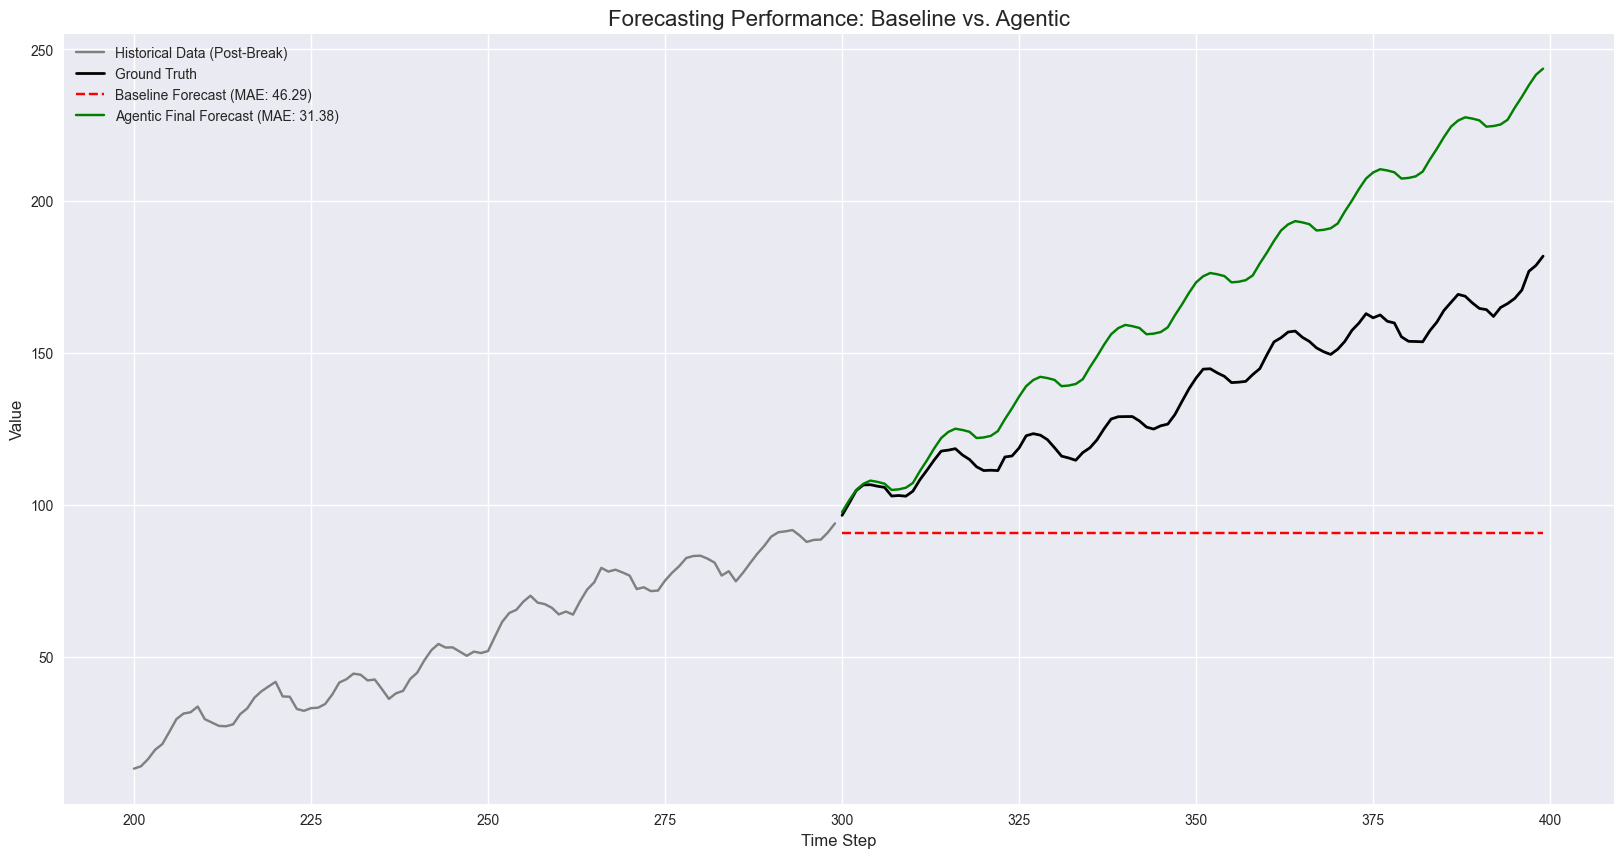

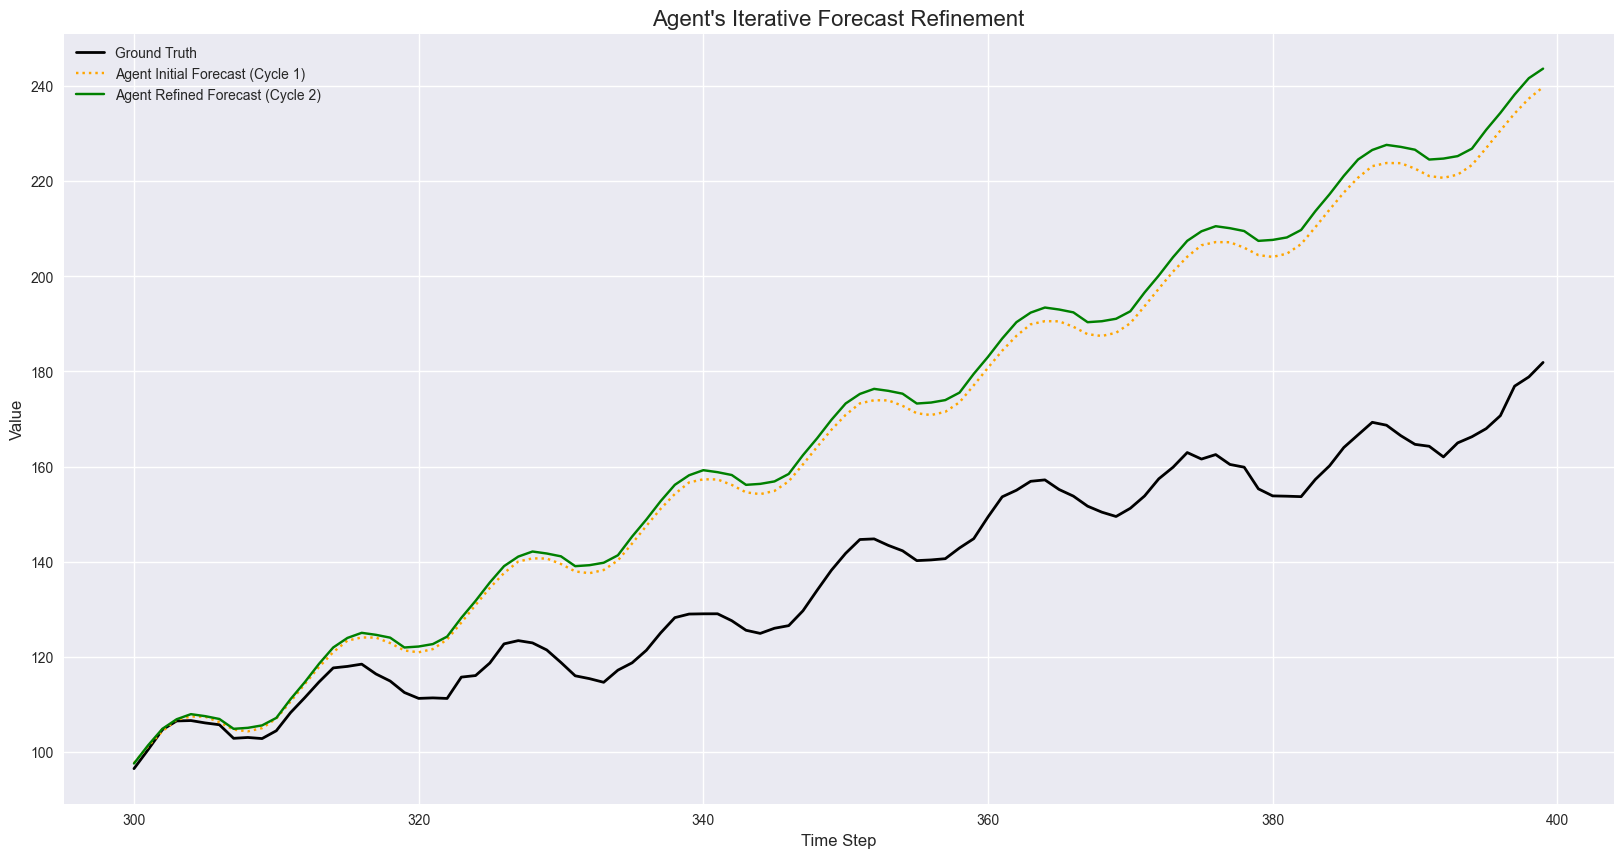

In [19]:
    # Visualizations
    time_future = np.arange(300, 400)
    
    # Plot 1: Baseline vs. Agentic Final Forecast
    plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
    plt.plot(np.arange(200, 300), history[200:], label='Historical Data (Post-Break)', color='gray')
    plt.plot(time_future, future, label='Ground Truth', color='black', linewidth=2, linestyle='-')
    plt.plot(time_future, baseline_pred, label=f'Baseline Forecast (MAE: {baseline_metrics["mae"]:.2f})', color='red', linestyle='--')
    plt.plot(time_future, final_agent_forecast, label=f'Agentic Final Forecast (MAE: {agent_final_metrics["mae"]:.2f})', color='green', linestyle='-')
    plt.title('Forecasting Performance: Baseline vs. Agentic', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.show()
    
    # Plot 2: Agent's Iterative Refinement
    plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
    plt.plot(time_future, future, label='Ground Truth', color='black', linewidth=2, linestyle='-')
    plt.plot(time_future, initial_agent_forecast, label='Agent Initial Forecast (Cycle 1)', color='orange', linestyle=':')
    plt.plot(time_future, final_agent_forecast, label='Agent Refined Forecast (Cycle 2)', color='green', linestyle='-')
    plt.title("Agent's Iterative Forecast Refinement", fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.show()

This code segment presents a clear and organized comparison of the forecasting performance between the baseline model (Simple Exponential Smoothing) and the agentic workflow.

It begins by printing a formatted table header with columns for "Approach," "MAE," and "MSE." Then, it prints two rows: one displaying the MAE and MSE values for the baseline model (`baseline_metrics`), and another showing the corresponding metrics for the final forecast generated by the agentic workflow (`agent_final_metrics`). The numbers are right-aligned within their columns for improved readability.

Next, it calculates the percentage improvement in both MAE and MSE achieved by the agentic approach compared to the baseline. This is done by subtracting the agent’s metric from the baseline metric, dividing the result by the baseline metric, and multiplying by 100.

Finally, it prints a section titled "Performance Improvement" and displays the calculated percentage improvements for MAE and MSE, formatted to two decimal places. This provides a concise summary of how much better the agentic workflow performed compared to the simple baseline model.